<a href="https://colab.research.google.com/github/AmandiW/ci-coursework/blob/main/final_moga_optimized_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
pip install deap

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import warnings

# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Suppress warnings
warnings.filterwarnings('ignore')

# Genetic Algorithm Libraries
from deap import base, creator, tools, algorithms


In [36]:
# Fix random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [62]:
class StrokeModelOptimizer:
    def __init__(self, filepath):
        """
        Initialize data, Genetic Algorithm (GA) settings, and constraints.
        """
        # Load and preprocess data
        self.X_train, self.X_test, self.y_train, self.y_test, self.scaler = self.load_and_preprocess_data(filepath)

        # Enhanced GA Configuration
        self.POPULATION_SIZE = 20
        self.MAX_GENERATIONS = 10
        self.CROSSOVER_PROB = 0.6
        self.MUTATION_PROB = 0.4

        # Gene configuration: ranges for hyperparameters with wider exploration
        self.GENE_CONFIGS = {
            'neurons_layer1': (32, 512),
            'neurons_layer2': (16, 256),
            'dropout_rate1': (0.1, 0.6),
            'dropout_rate2': (0.1, 0.4),
            'learning_rate': (0.0001, 0.01),
            'l2_reg': (1e-4, 1)
        }
        self.TRAINING_EPOCHS = 15

        # Tracking variables
        self.generation_best_loss = []
        self.generation_diversity = []
        self.generation_individuals = []
        self.generation_best_accuracy = []

        # Global Optima
        # Added a variable to track the absolute best individual across all generations
        self.absolute_best_individual = None
        self.absolute_best_fitness = (float('-inf'), float('inf'))  # Initialize with worst possible fitness

        self.setup_deap_framework()

    def load_and_preprocess_data(self, filepath):
        """Load dataset and preprocess."""
        df = pd.read_csv(filepath)
        X = df.drop('stroke', axis=1)
        y = df['stroke']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test, scaler

    def calculate_population_diversity(self, population):
        """Calculate population diversity based on gene variations"""
        if not population:
            return 0

        gene_diversity = []
        for gene_index in range(len(population[0])):
            gene_values = [ind[gene_index] for ind in population]
            gene_diversity.append(np.std(gene_values))
        return np.mean(gene_diversity)

    def setup_deap_framework(self):
        """Setup DEAP for GA optimization with enhanced diversity."""  # Fix to mitigate premature convergence
        creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Maximize accuracy, Minimize loss
        creator.create("Individual", list, fitness=creator.FitnessMulti)

        self.toolbox = base.Toolbox()

        # Gene initialization with more dynamic ranges
        for gene, (low, high) in self.GENE_CONFIGS.items():
            self.toolbox.register(f"attr_{gene}", random.uniform, low, high)

        self.toolbox.register("individual", tools.initCycle, creator.Individual,
                              (self.toolbox.attr_neurons_layer1,
                               self.toolbox.attr_neurons_layer2,
                               self.toolbox.attr_dropout_rate1,
                               self.toolbox.attr_dropout_rate2,
                               self.toolbox.attr_learning_rate,
                               self.toolbox.attr_l2_reg), n=1)

        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        # Enhanced crossover and mutation
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.3)

        def diversity_tournament_selection(individuals, k, tournsize=5):
            """Tournament selection with diversity consideration"""
            selected = []
            for _ in range(k):
                # Perform tournament selection
                tournament = random.sample(individuals, tournsize)
                # Select based on maximizing accuracy (the second element)
                winner = max(tournament, key=lambda ind: ind.fitness.values[0])
                selected.append(winner)
            return selected

        self.toolbox.register("select", diversity_tournament_selection)
        self.toolbox.register("evaluate", self.evaluate_individual)

    def build_ann(self, individual):
        """Build an ANN model based on individual hyperparameters."""
        neurons1, neurons2, drop1, drop2, lr, l2_reg = individual
        model = Sequential([
            Dense(int(neurons1), activation='relu', input_shape=(self.X_train.shape[1],),
                  kernel_regularizer=l2(l2_reg)),
            Dropout(drop1),
            Dense(int(neurons2), activation='relu', kernel_regularizer=l2(l2_reg)),
            Dropout(drop2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def evaluate_individual(self, individual):
        """Evaluate the performance of an ANN defined by individual genes."""
        try:
            # Build model using individual's genes
            model = self.build_ann(individual)

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            # Train the model
            model.fit(self.X_train, self.y_train,
                      epochs=self.TRAINING_EPOCHS,
                      batch_size=64,
                      validation_split=0.2,
                      verbose=0,
                      callbacks=[early_stopping])

            # Evaluate on test data
            loss, acc = model.evaluate(self.X_test, self.y_test, verbose=0)

            # Fitness: Minimize loss and maximize accuracy
            return acc, loss  # Note: Accuracy is negated for maximization
        except Exception as e:
            print(f"Evaluation error: {e}")
            return 0, 1e6  # Penalize invalid individuals

    def run_optimization(self):
        # Reset tracking variables
        self.generation_best_loss = []
        self.generation_diversity = []
        self.generation_individuals = []
        self.generation_best_accuracy = []

        # Create initial population
        pop = self.toolbox.population(n=self.POPULATION_SIZE)

        # Evaluate initial population
        fitnesses = list(map(self.toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

            # Check if this is the absolute best individual so far
            if self.is_individual_better(fit, self.absolute_best_fitness):
                self.absolute_best_individual = ind
                self.absolute_best_fitness = fit

        # Generational loop with enhanced tracking and diversity preservation
        for gen in range(self.MAX_GENERATIONS):
            # Calculate and track population diversity
            current_diversity = self.calculate_population_diversity(pop)
            self.generation_diversity.append(current_diversity)

            # Select next generation individuals
            offspring = self.toolbox.select(pop,
                                            len(pop) - self.POPULATION_SIZE // 10)  # Reduce size of offspring by 10%

            # Implement Elitism to make sure best individuals are taken forward
            elite = tools.selBest(pop, self.POPULATION_SIZE // 10)  # Select 10% of the population as elite
            offspring.extend(elite)  # Add elite individuals to the offspring

            offspring = list(map(self.toolbox.clone, offspring))

            # Apply crossover and mutation
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.CROSSOVER_PROB:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < self.MUTATION_PROB:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate individuals with invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

                # Check if this is the absolute best individual so far
                if self.is_individual_better(fit, self.absolute_best_fitness):
                    self.absolute_best_individual = ind
                    self.absolute_best_fitness = fit

            # Replace population
            pop[:] = offspring

            # Track generation best fitness
            best_ind = tools.selBest(pop, 1)[0]
            self.generation_best_loss.append(best_ind.fitness.values[1]) #CHNGD
            self.generation_best_accuracy.append(best_ind.fitness.values[0])  # Best accuracy

            # Track information about each individual in this generation
            self.generation_individuals.append([])  # Create an empty list for this generation
            for ind in offspring:
                ind_info = {"individual": ind, "fitness": ind.fitness.values}
                self.generation_individuals[-1].append(ind_info)  # Add info to current generation list

            # Print generation details
            print("")
            print(f"Generation {gen + 1}:")
            print(f"Diversity: {current_diversity}")
            print("\nAll Individuals in this Generation:")
            for i, ind_info in enumerate(self.generation_individuals[-1], 1):
                print(f"Individual {i}: {ind_info['individual']}")
                print(f"Fitness (Accuracy, Loss): {ind_info['fitness'][::-1]}\n")

            print("Best Individual Hyperparameters:", best_ind)
            print("")
            print(f"Best Accuracy: {best_ind.fitness.values[0]}")
            print(f"Best Loss: {best_ind.fitness.values[1]}")
            print("")
            print("Best Fitness (Accuracy, Loss):", best_ind.fitness.values)

        # Store the best overall individual
        self.best_individual = self.absolute_best_individual

        # Visualize results
        self.visualize_results(pop)

    def is_individual_better(self, new_fitness, current_best_fitness):
        """
        Compare two fitness values to determine if the new individual is better.
        Prioritize accuracy first, then consider loss.
        """
        # First, compare accuracy (higher is better)
        if -new_fitness[1] > -current_best_fitness[1]:
            return True
        # If accuracies are equal, compare loss (lower is better)
        elif -new_fitness[1] == -current_best_fitness[1] and new_fitness[0] < current_best_fitness[0]:
            return True
        return False

    def visualize_results(self, pop):
        # Create a figure with multiple subplots
        fig, axs = plt.subplots(3, 2, figsize=(15, 12))

        # 1. Convergence Plot (Accuracy)
        axs[0, 0].plot(range(1, len(self.generation_best_accuracy) + 1),
                       self.generation_best_accuracy, marker='o', color='orange', label="Best Accuracy")
        axs[0, 0].set_title('Convergence Plot (Accuracy)')
        axs[0, 0].set_xlabel('Generation')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].legend()

        # 2. Convergence Plot (Loss)
        axs[0, 1].plot(range(1, len(self.generation_best_loss) + 1),
                       self.generation_best_loss, marker='o', label="Best Loss")
        axs[0, 1].set_title('Convergence Plot (Loss)')
        axs[0, 1].set_xlabel('Generation')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()

        # 3. Pareto Front Visualization
        accuracies = [-ind.fitness.values[1] for ind in pop]  # Accuracy is now second element
        losses = [ind.fitness.values[0] for ind in pop]  # Loss is first element
        axs[1, 0].scatter(losses, accuracies, c='b', label="Pareto Front")
        axs[1, 0].set_xlabel("Loss")
        axs[1, 0].set_ylabel("Accuracy")
        axs[1, 0].set_title("Pareto Front Visualization")
        axs[1, 0].legend()

        # 4. Hyperparameter Distribution
        hyperparameter_names = ['Neurons Layer 1', 'Neurons Layer 2',
                                'Dropout Rate 1', 'Dropout Rate 2',
                                'Learning Rate', 'L2 Regularization']
        hyperparameter_values = list(zip(*pop))

        for i in range(len(hyperparameter_names)):
            axs[1, 1].hist(hyperparameter_values[i], bins=10,
                           alpha=0.5, label=hyperparameter_names[i])
        axs[1, 1].set_title('Hyperparameter Distribution')
        axs[1, 1].set_xlabel('Value')
        axs[1, 1].set_ylabel('Frequency')
        axs[1, 1].legend()

        # 5. Population Diversity Plot
        axs[2, 0].plot(range(1, len(self.generation_diversity) + 1), self.generation_diversity, marker='o',
                       color='green')
        axs[2, 0].set_title('Population Diversity Over Generations')
        axs[2, 0].set_xlabel('Generation')
        axs[2, 0].set_ylabel('Diversity Metric')

        # Remove the empty subplot
        fig.delaxes(axs[2, 1])

        plt.tight_layout()
        plt.show()

        # Use the best individual's hyperparameters to build and train the final model
        print("\nBest Overall Individual Hyperparameters:", self.best_individual)

        # Train with full training data using optimized hyperparameters
        neurons1, neurons2, drop1, drop2, lr, l2_reg = self.best_individual
        print("\nTraining Final Model with Optimized Hyperparameters:")
        print(f"Layer 1 Neurons: {int(neurons1)}")
        print(f"Layer 2 Neurons: {int(neurons2)}")
        print(f"Dropout Rate 1: {drop1}")
        print(f"Dropout Rate 2: {drop2}")
        print(f"Learning Rate: {lr}")
        print(f"L2 Regularization: {l2_reg}")

        # Build final model using BEST optimized hyperparameters
        final_model = self.build_ann(self.best_individual)

        # Train the model
        final_model.fit(self.X_train, self.y_train,
                        epochs=5,
                        batch_size=64,
                        validation_split=0.2,
                        verbose=1)

        # Predictions and Evaluation
        y_pred = (final_model.predict(self.X_test) > 0.5).astype(int)
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))

        # Additional Visualizations
        plt.figure(figsize=(15, 5))

        # Confusion Matrix
        plt.subplot(1, 3, 1)
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")

        # ROC Curve
        plt.subplot(1, 3, 2)
        fpr, tpr, _ = roc_curve(self.y_test, final_model.predict(self.X_test))
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()

        # Precision-Recall Curve
        plt.subplot(1, 3, 3)
        precision, recall, _ = precision_recall_curve(self.y_test, final_model.predict(self.X_test))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")

        plt.tight_layout()
        plt.show()

Evaluation error: Invalid value received for argument `rate`. Expected a float value between 0 and 1. Received: rate=1.1472091887603426
Evaluation error: Invalid value for argument l2: expected a non-negative float.Received: l2=-0.17456061750387802
Evaluation error: Invalid value for argument l2: expected a non-negative float.Received: l2=-0.5800553837751383

Generation 1:
Diversity: 35.457401498839836

All Individuals in this Generation:
Individual 1: [506.76126250375347, 193.30136535831014, 0.5111090258151056, 0.12360819008537721, 0.006844944135160942, 0.3011042142216555]
Fitness (Accuracy, Loss): (0.44379907846450806, 0.8856382966041565)

Individual 2: [55.304303945643085, 156.46668531012588, 1.1472091887603426, -0.031084525093812376, 0.005854751802031022, 0.021367487244639258]
Fitness (Accuracy, Loss): (1000000.0, 0.0)

Individual 3: [69.50723040009623, 205.46239705690581, 0.446350780173871, 0.15876427830508372, 0.0045437342240286244, 0.25505053124439875]
Fitness (Accuracy, Loss): 

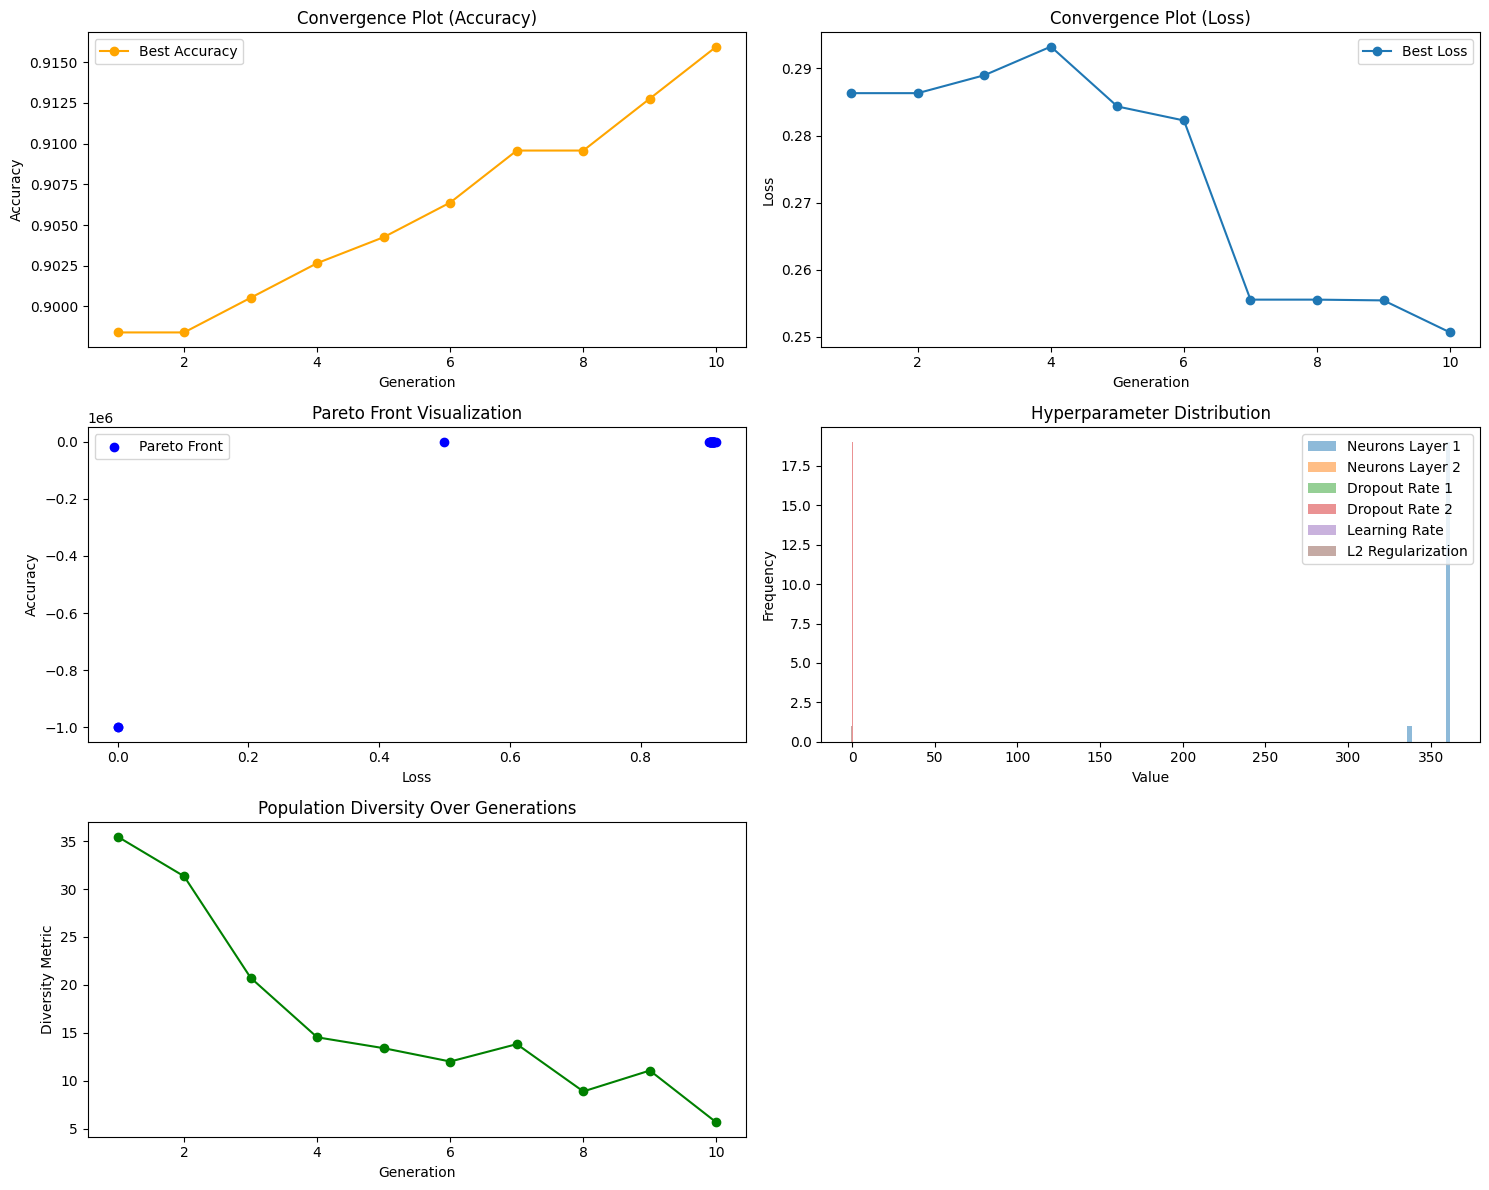


Best Overall Individual Hyperparameters: [361.2653450392003, 188.03035556013643, 0.0006096207647168228, 0.2288987212702442, 0.004866594902697613, 0.012406003390403833]

Training Final Model with Optimized Hyperparameters:
Layer 1 Neurons: 361
Layer 2 Neurons: 188
Dropout Rate 1: 0.0006096207647168228
Dropout Rate 2: 0.2288987212702442
Learning Rate: 0.004866594902697613
L2 Regularization: 0.012406003390403833
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8476 - loss: 1.3224 - val_accuracy: 0.8750 - val_loss: 0.3357
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8778 - loss: 0.3356 - val_accuracy: 0.8816 - val_loss: 0.3167
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8874 - loss: 0.3188 - val_accuracy: 0.8850 - val_loss: 0.3091
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8904 - loss: 0.3070 - val_accuracy: 0.8903 - val_loss: 0.3057
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8915 - loss: 0.2995 - v

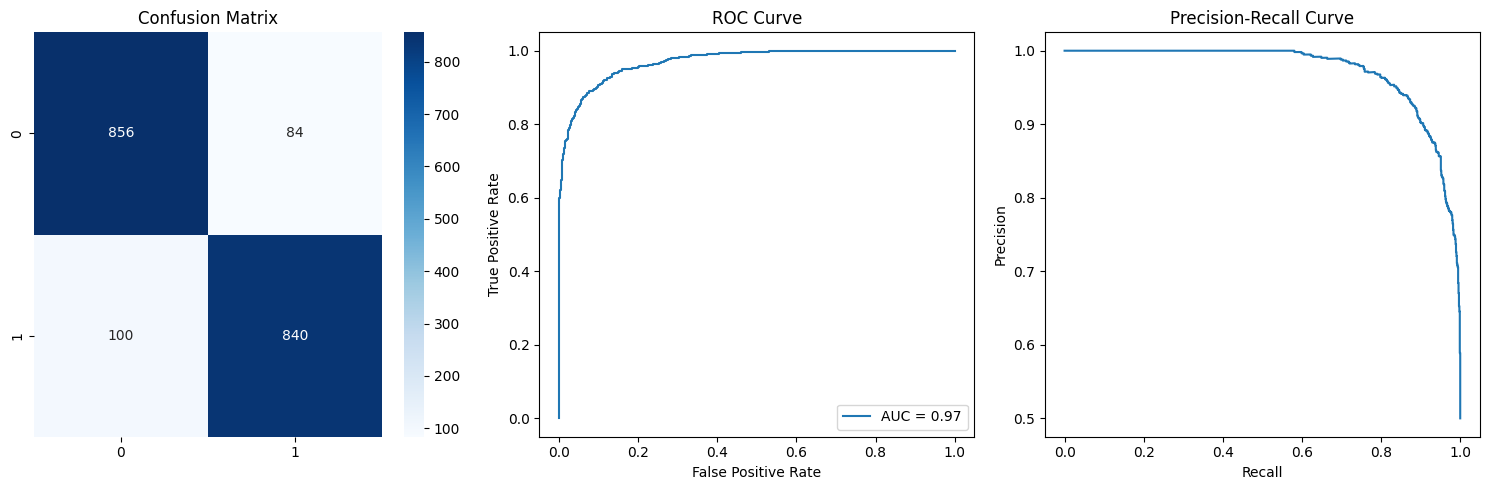

In [63]:
# Run the optimizer
if __name__ == "__main__":
    filepath = r"/content/sample_data/cleaned-stroke-prediction-dataset-balanced.csv"
    optimizer = StrokeModelOptimizer(filepath)
    optimizer.run_optimization()